# Basis comparison
Compare reconstruction performance of different choices of basis:
* Raw input
* SVD/POD modes
* Random projections

We'll perform comparisons using Olivetti faces dataset from AT&T.

In [83]:
from time import time
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets

import pysensors as ps

## Setup

Data consists of 10 pictures of 40 different people, each 64 x 64.

In [84]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [85]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [86]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

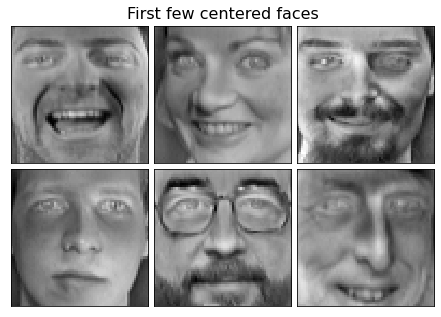

In [87]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [177]:
X_train, X_test = X[:300], X[300:]

In [178]:
from pydmd import DMD,HODMD
dmd = DMD(svd_rank=35,exact=False,opt=False)
dmd.fit(X_train.T)
U = dmd.modes
np.shape(U)
Hodmd = HODMD(svd_rank=35,d=5,exact=False,opt=False)
Hodmd.fit(X_train.T)
UHodmd = Hodmd.modes


In [198]:
from scipy import signal
import matplotlib.pyplot as plt
widths = np.arange(1, np.shape(X_train)[0]*np.shape(X_train)[1])
cwtmatr = signal.cwt(X_train.flatten, signal.ricker,widths)
cwtmatr

TypeError: object of type 'builtin_function_or_method' has no len()

## Reconstruction error

### Varying the number of basis modes
First we'll fix the number of sensors at 100 and see how the number of basis modes used affects the reconstruction error.

In [183]:
max_basis_modes = 200
n_sensors = 2

models = [
    (
        'Custom',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.Custom(n_basis_modes=max_basis_modes, U=U)
        )
    ),
    (
        'Custom',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.Custom(n_basis_modes=max_basis_modes, U=UHodmd)
        )
    ),

    (
        'Identity',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.Identity(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'SVD',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.SVD(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'Random Projection',
        ps.SSPOR(
            n_sensors=n_sensors,
            basis=ps.basis.RandomProjection(n_basis_modes=max_basis_modes)
        )
    ),
]

In [184]:
name,model1 = models[1]
model1

SSPOR(basis=<pysensors.basis._custom.Custom object at 0x7fe220f82d90>,
      n_sensors=2, optimizer=QR())

In [185]:
model1.basis.fit(X_train)
model1.basis.basis_matrix_

array([[ 0.01081226+0.0041771j ,  0.01081226-0.0041771j ,
         0.01053635+0.01299688j, ..., -0.01331744+0.01571602j,
        -0.01299805+0.j        ,  0.02183318+0.j        ],
       [ 0.01551894+0.00339955j,  0.01551894-0.00339955j,
         0.00992298+0.01392816j, ..., -0.01557961+0.01544972j,
        -0.01076506+0.j        ,  0.02271762+0.j        ],
       [ 0.01776523+0.00288624j,  0.01776523-0.00288624j,
         0.01055673+0.0140293j , ..., -0.01877962+0.01605825j,
        -0.00682095+0.j        ,  0.02672054+0.j        ],
       ...,
       [-0.02068003+0.01112751j, -0.02068003-0.01112751j,
        -0.0117961 -0.00428799j, ...,  0.02228742+0.00780084j,
        -0.01379396+0.j        , -0.01789464+0.j        ],
       [-0.02330952+0.01277846j, -0.02330952-0.01277846j,
        -0.01120195-0.00414563j, ...,  0.02323647+0.00901809j,
        -0.01178332+0.j        , -0.01430092+0.j        ],
       [-0.02258067+0.01353797j, -0.02258067-0.01353797j,
        -0.01094244-0.00395666

Train time for Custom basis: 4.0531158447265625e-06


/Users/abdomg/projects/pysensors/pysensors/reconstruction/_sspor.py:478: ComplexWarning: Casting complex values to real discards the imaginary part
  error[k] = score(


Train time for Custom basis: 3.0994415283203125e-06


/Users/abdomg/projects/pysensors/pysensors/reconstruction/_sspor.py:478: ComplexWarning: Casting complex values to real discards the imaginary part
  error[k] = score(


Train time for Identity basis: 0.002521038055419922
(4096, 200)
Train time for SVD basis: 0.0885918140411377
Train time for Random Projection basis: 0.013406753540039062


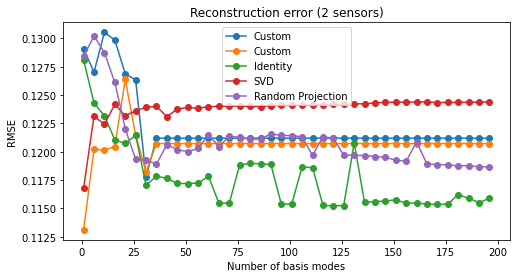

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of basis modes",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_sensors} sensors)",
)

n_basis_modes_range = np.arange(1, max_basis_modes, 5)

# Suppress warning arising from selecting fewer basis modes than
# the number of examples passed to the Identity basis
# (results in some examples being thrown away)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for name, model in models:
        t0 = -time()
        model.basis.fit(X_train)
        print(f"Train time for {name} basis: {time() + t0}")

        errors = np.zeros_like(n_basis_modes_range, dtype=np.float64)
        for k, n in enumerate(n_basis_modes_range):
            model.update_n_basis_modes(n, X_test, quiet=True)
            errors[k] = model.reconstruction_error(X_test, [n_sensors])[0]

        ax.plot(n_basis_modes_range, errors, "-o", label=name)

ax.legend()
plt.show()

In [169]:
from pydmd import DMD
dmd = DMD(svd_rank=0)
dmd.fit(X_train)
U = dmd.modes.real
model1.basis.basis_matrix_ = U
# model.fit(X_train)
model1.basis.basis_matrix_ 

array([[ 0.03725206,  0.03725206, -0.04305432, ...,  0.07484102,
         0.07484102,  0.07520393],
       [ 0.06861386,  0.06861386, -0.075698  , ..., -0.03332578,
        -0.03332578, -0.02807535],
       [-0.0798585 , -0.0798585 ,  0.02884919, ..., -0.04854688,
        -0.04854688, -0.05121052],
       ...,
       [-0.00837904, -0.00837904, -0.02156027, ..., -0.07699031,
        -0.07699031, -0.0671259 ],
       [ 0.09092192,  0.09092192,  0.01293033, ...,  0.02918206,
         0.02918206,  0.04691554],
       [-0.01964494, -0.01964494,  0.04019649, ..., -0.01040314,
        -0.01040314, -0.01088595]], dtype=float32)

In [170]:
max_basis_modes = 200
n_sensors = 100

models = [
    (
        'Identity',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.Custom(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'SVD',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.SVD(n_basis_modes=max_basis_modes)
        )
    ),
    (
        'Random Projection',
        ps.SSPOR(
            n_sensors=n_sensors, 
            basis=ps.basis.RandomProjection(n_basis_modes=max_basis_modes)
        )
    ),
]

Train time for Identity basis: 3.0994415283203125e-06


TypeError: 'NoneType' object is not subscriptable

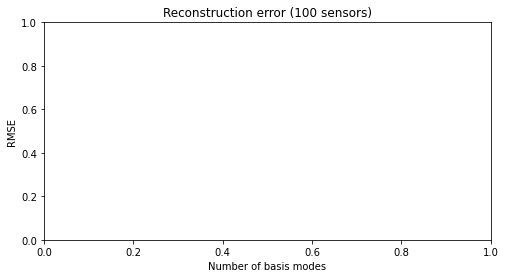

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of basis modes",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_sensors} sensors)",
)

n_basis_modes_range = np.arange(1, max_basis_modes, 5)

# Suppress warning arising from selecting fewer basis modes than
# the number of examples passed to the Identity basis
# (results in some examples being thrown away)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for name, model in models:
        t0 = -time()
        model.basis.fit(X_train)
        print(f"Train time for {name} basis: {time() + t0}")

        errors = np.zeros_like(n_basis_modes_range, dtype=np.float64)
        for k, n in enumerate(n_basis_modes_range):
            model.update_n_basis_modes(n, X_test, quiet=True)
            errors[k] = model.reconstruction_error(X_test, [n_sensors])[0]

        ax.plot(n_basis_modes_range, errors, "-o", label=name)

ax.legend()
plt.show()

The Random projection and Identity bases give similar performance, with Identity winning out for larger numbers of modes. The POD basis performs best for smaller numbers of modes, but its accuracy tapers off as the number of basis modes grows large.

### Varying the number of sensors
Next we'll explore the reconstruction error for a fixed number of basis modes (100) as the number of **sensors** is varied.

In [9]:
n_basis_modes = 100

models = [
    (
        'Identity',
        ps.SSPOR(basis=ps.basis.Identity(n_basis_modes=n_basis_modes))
    ),
    (
        'SVD',
        ps.SSPOR(basis=ps.basis.SVD(n_basis_modes=n_basis_modes))
    ),
    (
        'Random Projection',
        ps.SSPOR(basis=ps.basis.RandomProjection(n_basis_modes=n_basis_modes))
    ),
]

Train time for Identity basis: 0.015327930450439453
Train time for SVD basis: 0.037960052490234375
Train time for Random Projection basis: 0.018201112747192383


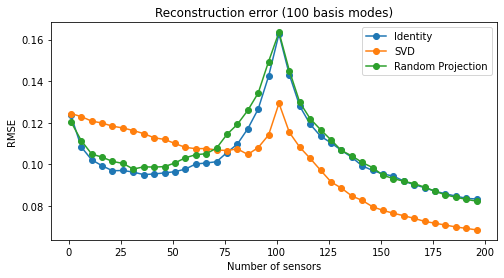

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set(
    xlabel="Number of sensors",
    ylabel="RMSE",
    title=f"Reconstruction error ({n_basis_modes} basis modes)",
)

sensor_range = np.arange(1, 200, 5)
for name, model in models:
    t0 = -time()
    model.fit(X_train, quiet=True)
    print(f"Train time for {name} basis: {time() + t0}")
    
    errors = model.reconstruction_error(X_test, sensor_range=sensor_range)
    ax.plot(sensor_range, errors, "-o", label=name)
    
ax.legend()
plt.show()

When the sensor count is small, Identity and Random projection bases produce the best reconstruction error. As the number of sensors grows, the POD basis wins out.

## Sensor locations
Let's compare the sensor locations for the three bases.

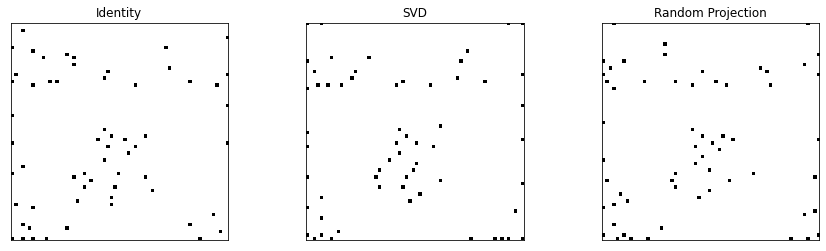

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
n_sensors = 60

for ax, (name, model) in zip(axs, models):
    img = np.zeros(n_features)
    sensors = model.get_all_sensors()[:n_sensors]
    img[sensors] = 16
    
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
    ax.set(title=name, xticks=[], yticks=[])

Similar sensor locations are chosen for this dataset across all three bases considered.